# Multi-Label Classification of Handwritten Letters

## Step 0. Style and Libraries

In [4]:
library(IRdisplay)
library(repr)
library(tensorflow)
library(keras)
library(imager)
library(R6)

In [2]:
keras_backend <- backend()

In [3]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #818286; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}
</style>")

## Step 1. Load and Explore the Data

In [5]:
letters1 <- read.csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data/letters.csv")
letters2 <- read.csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/letters2.csv")
head(letters1)

letter,label,file,background
а,1,01_01.png,0
а,1,01_02.png,0
а,1,01_03.png,0
а,1,01_04.png,0
а,1,01_05.png,0
а,1,01_06.png,0


In [6]:
image_paths1 <- list.files("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data", 
                           recursive = TRUE, full.names = TRUE)
image_paths1 <- image_paths1[1:(length(image_paths1)-3)]
image_paths2 <- list.files("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2", 
                           recursive = TRUE, full.names = TRUE)
image_paths2 <- image_paths2[1:(length(image_paths2)-3)]
tail(image_paths2)

[1] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_94.png"
[2] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_95.png"
[3] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_96.png"
[4] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_97.png"
[5] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_98.png"
[6] "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/33_99.png"

In [7]:
letter_targets1 <- as.matrix(letters1["label"])
letter_targets2 <- as.matrix(letters2["label"])
letter_targets1 <- keras::to_categorical(letter_targets1-1,33)
letter_targets2 <- keras::to_categorical(letter_targets2-1,33)
head(letter_targets1,3)

1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 32 32  1  4

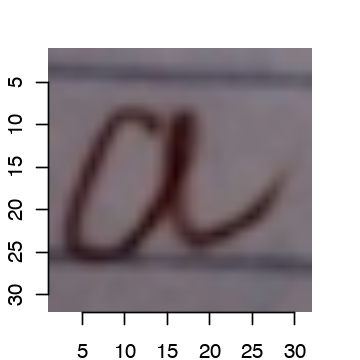

In [8]:
im <- load.image("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data/01_05.png")
options(repr.plot.width=3,repr.plot.height=3)
par(mar=c(2,2,2,2))
dim(im)
plot(im)

In [9]:
image_loading <- function(image_path) {
    image <- keras::image_load(image_path, target_size=c(32,32))
    image <- image_to_array(image) / 255
    image <- array_reshape(image, c(1, dim(image)))
    return(image)
}

In [10]:
letter_tensors1 <- lapply(image_paths1, image_loading)
letter_tensors2 <- lapply(image_paths2, image_loading)

In [11]:
letter_tensors1 <- array_reshape(letter_tensors1, c(-1,32*32*3))
letter_tensors2 <- array_reshape(letter_tensors2, c(-1,32*32*3))
dim(letter_tensors1); dim(letter_targets1); dim(letter_tensors2); dim(letter_targets2)

[1] 1650 3072

[1] 1650   33

[1] 5940 3072

[1] 5940   33

In [12]:
letter_tensors <- rbind(letter_tensors1,letter_tensors2)
letter_targets <- rbind(letter_targets1,letter_targets2)

In [13]:
dim(letter_tensors); dim(letter_targets);

[1] 7590 3072

[1] 7590   33

In [14]:
df <- data.frame(letter_tensors,letter_targets)
df <- df[sample(nrow(df)),]
dim(df)

[1] 7590 3105

[1] 32 32  3

[1] 21

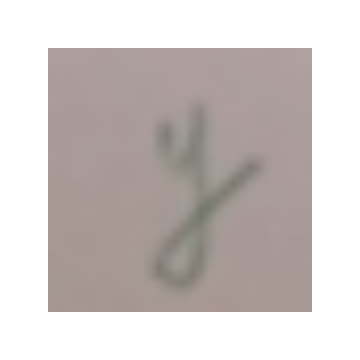

In [15]:
options(repr.plot.width=3,repr.plot.height=3)
par(mar=c(2,2,2,2))
image_example <- df[100,1:3072]
image_example <- array_reshape(as.matrix(df[100,1:3072]),c(32,32,3))
dim(image_example)
which(df[100,3073:3105]==1)
plot(as.raster(image_example))

In [16]:
train_indices <- 1:round(0.7 * nrow(df))
valid_indices <- (round(0.7 * nrow(df)) + 1):round(0.85 * nrow(df))
test_indices <- (round(0.85 * nrow(df)) + 1):nrow(df)

In [17]:
x_train <- as.matrix(df[train_indices,1:3072])
y_train <- as.matrix(df[train_indices,3073:3105])
x_valid <- as.matrix(df[valid_indices,1:3072])
y_valid <- as.matrix(df[valid_indices,3073:3105])
x_test <- as.matrix(df[test_indices,1:3072])
y_test <- as.matrix(df[test_indices,3073:3105])

In [18]:
dim(x_train); dim(x_valid); dim(x_test); dim(y_train); dim(y_valid); dim(y_test)

[1] 5313 3072

[1] 1139 3072

[1] 1138 3072

[1] 5313   33

[1] 1139   33

[1] 1138   33

In [21]:
image_grayscaled_loading <- function(image_path) {
    image <- keras::image_load(image_path, 
                               target_size=c(32,32),
                               grayscale=T)
    image <- image_to_array(image) / 255
    image <- array_reshape(image, c(1, dim(image)))
    return(image)
}

In [22]:
gray_letter_tensors1 <- lapply(image_paths1, image_grayscaled_loading)
gray_letter_tensors2 <- lapply(image_paths2, image_grayscaled_loading)
gray_letter_tensors1 <- array_reshape(gray_letter_tensors1, c(-1,32*32))
gray_letter_tensors2 <- array_reshape(gray_letter_tensors2, c(-1,32*32))

In [24]:
dim(gray_letter_tensors1); dim(letter_targets1); dim(gray_letter_tensors2); dim(letter_targets2)

[1] 1650   32   32    1

[1] 1650   33

[1] 5940   32   32    1

[1] 5940   33

In [25]:
gray_letter_tensors <- rbind(gray_letter_tensors1,gray_letter_tensors2)

In [26]:
dim(gray_letter_tensors); dim(letter_targets);

[1] 7590 1024

[1] 7590   33

In [28]:
gray_df <- data.frame(gray_letter_tensors,letter_targets)
gray_df <- gray_df[sample(nrow(gray_df)),]
dim(gray_df)

[1] 7590 1057

[1] 32 32

[1] 20

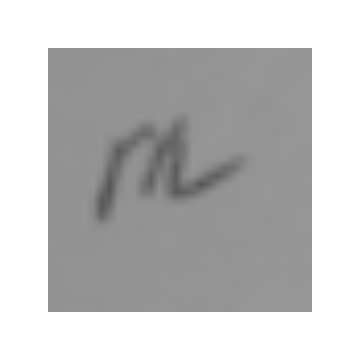

In [30]:
options(repr.plot.width=3,repr.plot.height=3)
par(mar=c(2,2,2,2))
gray_image_example <- gray_df[100,1:1024]
gray_image_example <- array_reshape(as.matrix(gray_df[100,1:1024]),c(32,32))
dim(gray_image_example)
which(gray_df[100,1025:1057]==1)
plot(as.raster(gray_image_example))

In [31]:
x_train2 <- as.matrix(gray_df[train_indices,1:1024])
y_train2 <- as.matrix(gray_df[train_indices,1025:1057])
x_valid2 <- as.matrix(gray_df[valid_indices,1:1024])
y_valid2 <- as.matrix(gray_df[valid_indices,1025:1057])
x_test2 <- as.matrix(gray_df[test_indices,1:1024])
y_test2 <- as.matrix(gray_df[test_indices,1025:1057])

In [32]:
dim(x_train2); dim(x_valid2); dim(x_test2); dim(y_train2); dim(y_valid2); dim(y_test2)

[1] 5313 1024

[1] 1139 1024

[1] 1138 1024

[1] 5313   33

[1] 1139   33

[1] 1138   33

## Step 2. Create a One-Label Classification Model

In [19]:
# CNN
cnn_model <- keras_model_sequential()

cnn_model %>%  
  
layer_conv_2d(filter=32,kernel_size=c(5,5),padding="same",
              input_shape=c(32,32,3) ) %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
  
layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.2) %>%

layer_conv_2d(filter=196,kernel_size=c(5,5)) %>% 
layer_activation_leaky_relu(alpha=0.02) %>%  

layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.2) %>%

layer_global_max_pooling_2d() %>%  

layer_dense(1024) %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
layer_dropout(0.5) %>%  
  
layer_dense(33) %>%    
layer_activation("softmax")

In [20]:
cnn_model %>%
  compile(loss="categorical_crossentropy",optimizer="adam",metrics="accuracy")

In [21]:
cnn_fit <- cnn_model %>%
  fit(x=array_reshape(x_train,c(-1,32,32,3)),
      y=y_train,
      validation_data=list(array_reshape(x_valid,c(-1,32,32,3)),y_valid),
      shuffle=T,
      batch_size=64,
      epochs=150,
      callbacks=list(callback_model_checkpoint("cnn_best_letters.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.1)))

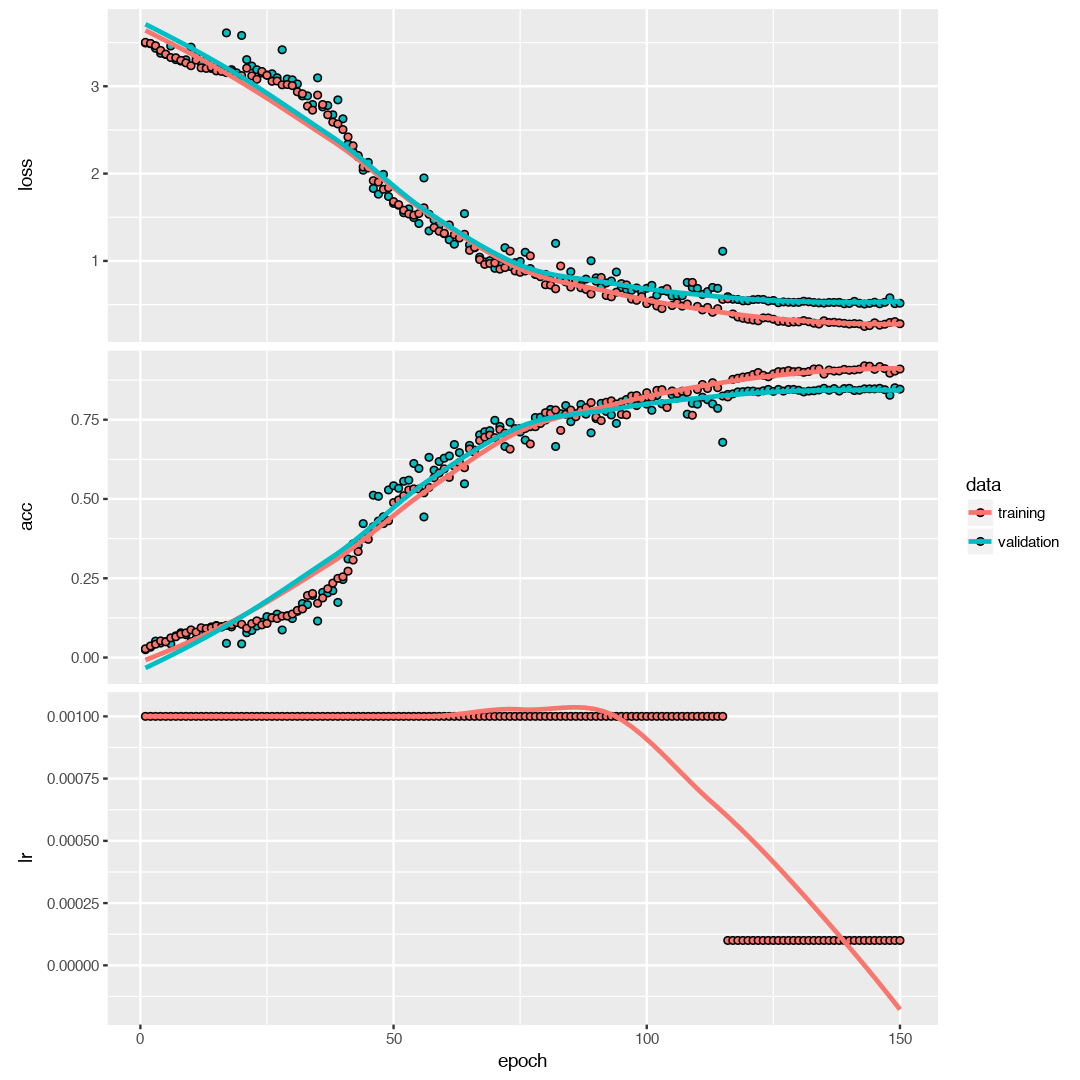

In [22]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(cnn_fit)

In [23]:
cnn_fit_df <- as.data.frame(cnn_fit)
cnn_fit_df[251:300,1:4]

,epoch,value,metric,data
251,101,0.7796313,acc,validation
252,102,0.8261633,acc,validation
253,103,0.7998244,acc,validation
254,104,0.7971905,acc,validation
255,105,0.8287972,acc,validation
256,106,0.8182616,acc,validation
257,107,0.8208955,acc,validation
258,108,0.7673398,acc,validation
259,109,0.8015803,acc,validation
260,110,0.7989464,acc,validation


In [24]:
load_model_weights_hdf5(cnn_model,"cnn_best_letters.h5")

In [25]:
cnn_score <- cnn_model %>% 
    evaluate(array_reshape(x_test,c(-1,32,32,3)),y_test)
cnn_score

$loss
[1] 0.52888

$acc
[1] 0.8453427

In [34]:
# CNN
gray_cnn_model <- keras_model_sequential()

gray_cnn_model %>%  
  
layer_conv_2d(filter=32,kernel_size=c(5,5),padding="same",
              input_shape=c(32,32,1) ) %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
  
layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.2) %>%

layer_conv_2d(filter=256,kernel_size=c(5,5)) %>% 
layer_activation_leaky_relu(alpha=0.02) %>%  

layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.2) %>%

layer_global_max_pooling_2d() %>%  

layer_dense(1024) %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
layer_dropout(0.5) %>%  
  
layer_dense(33) %>%    
layer_activation("softmax")

In [35]:
gray_cnn_model %>%
  compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics="accuracy")

In [43]:
gray_cnn_fit <- gray_cnn_model %>%
  fit(x=array_reshape(x_train2,c(-1,32,32,1)),
      y=y_train2,
      validation_data=list(array_reshape(x_valid2,c(-1,32,32,1)),y_valid2),
      shuffle=T,
      batch_size=64,
      epochs=100,
      callbacks=list(callback_model_checkpoint("gray_cnn_best_letters.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.1)))

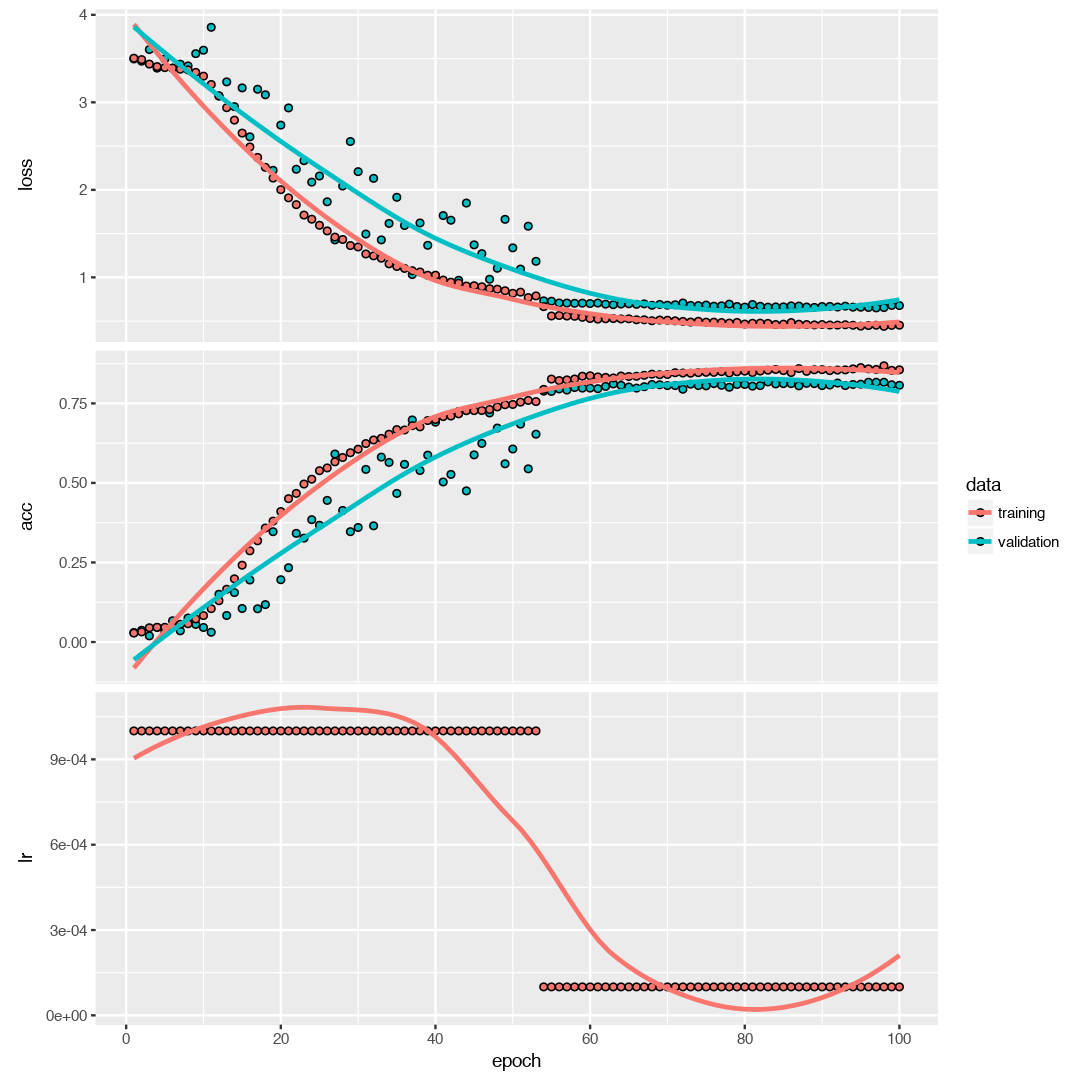

In [44]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(gray_cnn_fit)

In [45]:
gray_cnn_fit_df <- as.data.frame(gray_cnn_fit)
gray_cnn_fit_df[151:200,1:4]

,epoch,value,metric,data
151,51,0.6848112,acc,validation
152,52,0.5443371,acc,validation
153,53,0.6532046,acc,validation
154,54,0.7884109,acc,validation
155,55,0.7875329,acc,validation
156,56,0.7954346,acc,validation
157,57,0.7919227,acc,validation
158,58,0.7998244,acc,validation
159,59,0.7980685,acc,validation
160,60,0.7980685,acc,validation


In [46]:
load_model_weights_hdf5(gray_cnn_model,"gray_cnn_best_letters.h5")

In [47]:
gray_cnn_score <- gray_cnn_model %>% 
    evaluate(array_reshape(x_test2,c(-1,32,32,1)),y_test2)
gray_cnn_score

$loss
[1] 0.6394293

$acc
[1] 0.8242531